<a href="https://colab.research.google.com/github/anushkav1888/WIDS_RL/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow import keras
import imageio
import random
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, LSTM, Reshape, Dropout, Conv2D, Flatten
from keras.optimizers import Adam
envCartPole = gym.make('CartPole-v1')
envCartPole.seed(50)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


[50]

In [2]:
EPISODES = 120
TRAIN_END = 0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
#Hyper Parameters
def discount_rate(): #Gamma
    return 0.95

def learning_rate(): #Alpha
    return 0.001

def batch_size(): #Size of the batch used in the experience replay
    return 24

In [4]:
class DeepQNetwork():
    def __init__(self, states, actions, alpha, gamma, epsilon,epsilon_min, epsilon_decay):
        self.nS = states
        self.nA = actions
        self.memory = deque([], maxlen=2500)
        self.alpha = alpha
        self.gamma = gamma
        #Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self.build_model()
        self.loss = []

    def build_model(self):
        model = keras.Sequential()
        model.add(Dense(512, input_dim=self.nS, activation='relu'))
        model.add(Dropout(0.5))  # Adding dropout with a rate of 0.5
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))  # Adding dropout with a rate of 0.5
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.5))  # Adding dropout with a rate of 0.5
        model.add(Dense(self.nA, activation='linear'))
        model.compile(loss='mean_squared_error',
                      optimizer=keras.optimizers.Adam(lr=self.alpha))
        return model

    def action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.nA) #Explore
        action_vals = self.model.predict(state) #Exploit: Use the NN to predict the correct action from this state
        return np.argmax(action_vals[0])

    def test_action(self, state): #Exploit
        action_vals = self.model.predict(state)
        return np.argmax(action_vals[0])

    def store(self, state, action, reward, nstate, done):
        #Store the experience in memory
        self.memory.append( (state, action, reward, nstate, done) )

    def experience_replay(self, batch_size):
        #Execute the experience replay
        minibatch = random.sample( self.memory, batch_size ) #Randomly sample from memory

        #Convert to numpy for speed by vectorization
        x = []
        y = []
        np_array = np.array(minibatch)
        st = np.zeros((0,self.nS)) #States
        nst = np.zeros( (0,self.nS) )#Next States
        for i in range(len(np_array)): #Creating the state and next state np arrays
            st = np.append( st, np_array[i,0], axis=0)
            nst = np.append( nst, np_array[i,3], axis=0)
        st_predict = self.model.predict(st)
        nst_predict = self.model.predict(nst)
        index = 0
        for state, action, reward, nstate, done in minibatch:
            x.append(state)
            #Predict from state
            nst_action_predict_model = nst_predict[index]
            if done == True: #Terminal: Just assign reward much like {* (not done) - QB[state][action]}
                target = reward
            else:   #Non terminal
                target = reward + self.gamma * np.amax(nst_action_predict_model)
            target_f = st_predict[index]
            target_f[action] = target
            y.append(target_f)
            index += 1
        #Reshape for Keras Fit
        x_reshape = np.array(x).reshape(batch_size,self.nS)
        y_reshape = np.array(y)
        epoch_count = 1 #Epochs is the number or iterations
        hist = self.model.fit(x_reshape, y_reshape, epochs=epoch_count, verbose=0)
        #Graph Losses
        for i in range(epoch_count):
            self.loss.append( hist.history['loss'][i] )
        #Decay Epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [5]:
#Create the agent
nS = envCartPole.observation_space.shape[0] #This is only 4
nA = envCartPole.action_space.n #Actions
dqn = DeepQNetwork(nS, nA, learning_rate(), discount_rate(), 1, 0.001, 0.995 )
batch_size = batch_size()

In [6]:
# Training
rewards = []  # Store rewards for graphing
epsilons = []  # Store the Explore/Exploit
TEST_Episodes = 0

for e in range(EPISODES):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS])  # Resize to store in memory to pass to .predict
    tot_rewards = 0

    for time in range(210):
        action = dqn.action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape(nstate, [1, nS])
        tot_rewards += reward
        dqn.store(state, action, reward, nstate, done)  # Resize to store in memory to pass to .predict
        state = nstate

        # done: CartPole fell.
        # time == 209: CartPole stayed upright
        if done or time == 209:
            rewards.append(tot_rewards)
            epsilons.append(dqn.epsilon)
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e, EPISODES, tot_rewards, dqn.epsilon))
            break

        # Experience Replay
        if len(dqn.memory) > batch_size:
            dqn.experience_replay(batch_size)


    if len(rewards) > 5 and np.average(rewards[-5:]) > 195:
        # Set the rest of the EPISODES for testing
        TEST_Episodes = EPISODES - e
        TRAIN_END = e
        break
# Save the model weights
dqn.model.save_weights('/content/drive/MyDrive/weights.h5')


<ipython-input-4-84b2a4051358>:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np_array = np.array(minibatch)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 18ms/step
episode: 68/120, score: 210.0, e: 0.0009954703940636294
1/1 [==============================] - 0s 17ms/step
episode: 69/120, score: 97.0, e: 0.0009954703940636294
1/1 [==============================] - 0s 16ms/step
episode: 70/120, score: 20.0, e: 0.0009954703940636294
1/1 [==============================] - 0s 23ms/step
episode: 71/120, score: 12.0, e: 0.0009954703940636294
1/1 [==============================] - 0s 21ms/step
episode: 72/120, score: 8.0, e: 0.0009954703940636294
1/1 [==============================] - 0s 21ms/step
episode: 73/120, score: 16.0, e: 0.0009954703940636294
1/1 [==============================] - 0s 24ms/step
episode: 74/120, score: 142.0, e: 0.0009954703940636294
1/1 [==============================] - 0s 21ms/step
episode: 75/120, score: 102.0, e: 0.0009954703940636294
1/1 [==============================] - 0s 18ms/step
episode: 76/120, score: 17.0, e: 0.0009

In [7]:
# Function to run an episode with the trained model
def run_episode(model, environment, max_frames=None, max_steps=20000):  # Increase max_steps as needed
    state = environment.reset()
    done = False
    total_reward = 0
    frames = []  # To store frames for video recording

    step_count = 0

    while not done and (max_frames is None or len(frames) < max_frames) and step_count < max_steps:
        # Choose action using the trained model
        action_prob = model.predict(np.expand_dims(state, axis=0))[0]
        action_prob /= np.sum(action_prob)
        action = np.random.choice(len(action_prob), p=action_prob)

        # Take the chosen action
        next_state, reward, done, _ = environment.step(action)

        # Update total reward
        total_reward += reward

        # Update state for the next step
        state = next_state

        # Render the environment and append the frame to the list
        frames.append(environment.render(mode='rgb_array'))

        step_count += 1

    return total_reward, frames

# Create CartPole environment
env = gym.make('CartPole-v1')

# Load the trained model weights
# Assuming 'dqn' is already defined somewhere in your code
dqn.model.load_weights('/content/drive/MyDrive/weights.h5')

# Run the trained model for a specified number of episodes
num_episodes = 1  # Change this number to the desired number of episodes

for episode in range(num_episodes):
    demo_reward, demo_frames = run_episode(dqn.model, env, max_frames=500, max_steps=1000)
    print(f"Episode {episode + 1} - Reward: {demo_reward}")

    # Save frames as a video with increased fps (e.g., 60 fps)
    video_path = f'demo_video_{episode + 1}.mp4'
    imageio.mimsave(video_path, demo_frames, fps=60)
    print(f"Demo video saved at: {video_path}")

# Close the environment
env.close()


1/1 [==============================] - 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


1/1 [==============================] - 0s 18ms/step
Episode 1 - Reward: 14.0


Demo video saved at: demo_video_1.mp4


In [15]:
# Test the agent that was trained
# In this section, we ALWAYS use exploitation, don't train any more
for e_test in range(TEST_Episodes):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0

    for t_test in range(210):
        action = dqn.test_action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape(nstate, [1, nS])
        tot_rewards += reward
        state = nstate

        # Print information at every step
        print("Episode: {}/{}, Step: {}/{}, Score: {}, Epsilon: {}"
              .format(e_test + 1, TEST_Episodes, t_test + 1, 210, tot_rewards, 0))

        # Check for termination conditions
        if done or t_test == 209:
            rewards.append(tot_rewards)
            epsilons.append(0)  # We are doing full exploitation
            print("Episode: {}/{}, Score: {}, Epsilon: {}"
                  .format(e_test + 1, TEST_Episodes, tot_rewards, 0))
            break


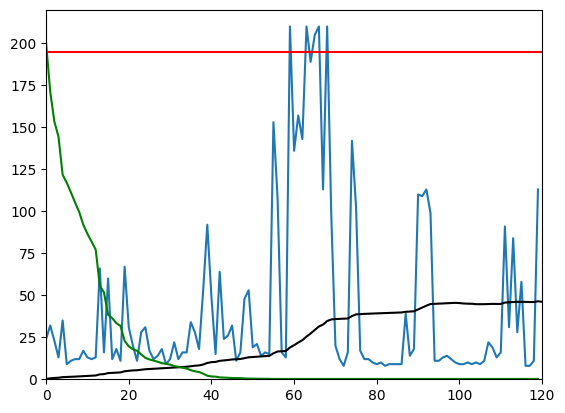

In [9]:
rolling_average = np.convolve(rewards, np.ones(100)/100)

plt.plot(rewards)
plt.plot(rolling_average, color='black')
plt.axhline(y=195, color='r', linestyle='-') #Solved Line
#Scale Epsilon (0.001 - 1.0) to match reward (0 - 200) range
eps_graph = [200*x for x in epsilons]
plt.plot(eps_graph, color='g', linestyle='-')
#Plot the line where TESTING begins
plt.axvline(x=TRAIN_END, color='y', linestyle='-')
plt.xlim( (0,EPISODES) )
plt.ylim( (0,220) )
plt.show()


envCartPole.close()

Average total reward for random agent: 20.891666666666666


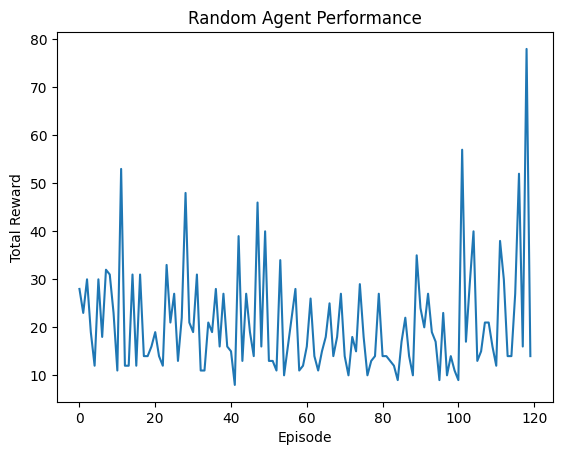

In [19]:

class RandomAgent:
    def __init__(self, action_space):
        self.action_space = action_space

    def action(self, state):
        # Randomly choose an action from the action space
        return np.random.choice(self.action_space.n)

# Assuming 'envCartPole' is your environment
action_space = envCartPole.action_space
random_agent = RandomAgent(action_space)
random_agent_episodes = 120

# Run a demo with the random agent
random_agent_rewards = [run_episode(random_agent, envCartPole) for _ in range(random_agent_episodes)]

# Print and compare average rewards
avg_random_agent_reward = np.mean(random_agent_rewards)
print(f"Average total reward for random agent: {avg_random_agent_reward}")

# Plot the rewards
plt.plot(random_agent_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Random Agent Performance')
plt.show()
